<a href="https://colab.research.google.com/github/rozariwang/DS_project/blob/main/CoLi_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computational Linguistics 23/24 Final Project** <br>
Name: Ho-Hsuan Wang <br>
Student Number: 7038925 <br>
Date: 22nd March <br>

## 1. Download and Inspect Datasets

In [1]:
pip install requests conllu


In [2]:
import requests
from conllu import parse
from io import StringIO

Link to UD_Chinese-GSD repository: https://github.com/UniversalDependencies/UD_Chinese-GSD

Description: UD_Chinese-GSD is a traditional Chinese Universal Dependencies Treebank annotated and converted by Google.

In [3]:

links_to_datasets = {
    "train": "https://raw.githubusercontent.com/UniversalDependencies/UD_Chinese-GSD/master/zh_gsd-ud-train.conllu",
    "test": "https://raw.githubusercontent.com/UniversalDependencies/UD_Chinese-GSD/master/zh_gsd-ud-test.conllu",
    "dev": "https://raw.githubusercontent.com/UniversalDependencies/UD_Chinese-GSD/master/zh_gsd-ud-dev.conllu",
}

def download_and_parse(url):
    response = requests.get(url)
    response.raise_for_status()
    file_content = response.text
    parsed_data = parse(file_content)
    return parsed_data
'''
# Column headers and descriptions
columns_info = {
    "ID": "Token ID, integer or decimal for multiword tokens",
    "FORM": "Form or spelling of the word",
    "LEMMA": "Lemma or base form of the word",
    "UPOS": "Universal Part-of-Speech tag",
    "XPOS": "Language-specific part-of-speech tag",
    "FEATS": "Morphological features",
    "HEAD": "Head of the current token in a dependency parse",
    "DEPREL": "Dependency relation to the HEAD",
    "DEPS": "Enhanced dependency graph",
    "MISC": "Any other annotation"
}

datasets = {name: download_and_parse(url) for name, url in links_to_datasets.items()}

# Print column information
print("CoNLL-U Format Columns:")
for column, description in columns_info.items():
    print(f"{column}: {description}")
print("\n---\n")

# Print dataset information
for name, data in datasets.items():
    print(f"Dataset: {name}, Sentences: {len(data)}")
    if data:
        first_sentence = data[0]
        print(f"# sent_id = {first_sentence.metadata['sent_id']}")
        print(f"# text = {first_sentence.metadata['text']}")
        if 'translit' in first_sentence.metadata:
            print(f"# translit = {first_sentence.metadata['translit']}")
        for token in first_sentence:
            print(f"{token['id']}\t{token['form']}\t{token['lemma']}\t{token['upos']}\t{token['xpos']}\t{'_'}\t{token.get('head', '_')}\t{token['deprel']}\t{'_'}\t{'|'.join([f'{k}={v}' for k, v in token['misc'].items()]) if token['misc'] else '_'}")
    print("\n---\n")
    '''

'\n# Column headers and descriptions\ncolumns_info = {\n    "ID": "Token ID, integer or decimal for multiword tokens",\n    "FORM": "Form or spelling of the word",\n    "LEMMA": "Lemma or base form of the word",\n    "UPOS": "Universal Part-of-Speech tag",\n    "XPOS": "Language-specific part-of-speech tag",\n    "FEATS": "Morphological features",\n    "HEAD": "Head of the current token in a dependency parse",\n    "DEPREL": "Dependency relation to the HEAD",\n    "DEPS": "Enhanced dependency graph",\n    "MISC": "Any other annotation"\n}\n\ndatasets = {name: download_and_parse(url) for name, url in links_to_datasets.items()}\n\n# Print column information\nprint("CoNLL-U Format Columns:")\nfor column, description in columns_info.items():\n    print(f"{column}: {description}")\nprint("\n---\n")\n\n# Print dataset information\nfor name, data in datasets.items():\n    print(f"Dataset: {name}, Sentences: {len(data)}")\n    if data:\n        first_sentence = data[0]\n        print(f"# sent_

## 2. Data Preprocessing

Preprocess the data from the CoNLL-U files and prepares it for training the XLM-RoBERTa model. <br>

- Tokenize and align the data (align the POS tags with the subword tokens) using the XLMRobertaTokenizerFast since XLM-RoBERTa uses subword tokenization.

In [4]:
pip install transformers datasets torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00


In [11]:
from transformers import XLMRobertaForTokenClassification, XLMRobertaTokenizerFast
from transformers import Trainer, TrainingArguments
import requests
from conllu import parse
from torch.utils.data import Dataset
import numpy as np
import torch

In [12]:
model_name = "xlm-roberta-base"

dataset = download_and_parse(links_to_datasets["train"])

# Initialize the tokenizer
tokenizer = XLMRobertaTokenizerFast.from_pretrained(model_name)

def align_tokens_and_labels(sentence, label_field='upos'):
    tokens = [token['form'] for token in sentence]  # Original words from the sentence
    labels = [token[label_field] for token in sentence]  # Corresponding labels

    # Tokenize the sentence, indicating that the input is pre-tokenized
    tokenized_input = tokenizer(tokens, is_split_into_words=True, return_tensors="pt")
    word_ids = tokenized_input.word_ids(batch_index=0)

    aligned_labels = []
    # Iterate over word_ids to assign labels correctly
    for i, word_idx in enumerate(word_ids):
        if word_idx is None:
            aligned_labels.append(-100)  # Assign -100 to special tokens
        else:
            # If the token starts with "▁" and is not just "▁", assign the label
            if tokenized_input.tokens()[i].startswith("▁") and len(tokenized_input.tokens()[i]) > 1:
                aligned_labels.append(labels[word_idx])
            elif not tokenized_input.tokens()[i].startswith("▁"):
                # Assign the label to the actual word token (not the underscore)
                aligned_labels.append(labels[word_idx])
            else:
                # If it's just "▁", assign -100
                aligned_labels.append(-100)

    return tokenized_input, aligned_labels


##### Check if the tokenise and align functions correctly #####
# Align tokens and labels for the first sentence as an example
first_sentence = dataset[0]
tokenized_input, aligned_labels = align_tokens_and_labels(first_sentence)

print(first_sentence)
print("Tokenized input:", tokenized_input)
print("Aligned labels:", aligned_labels)

# Convert token IDs back to tokens (words/subwords)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'][0])

# Print each token with its aligned label
for token, label in zip(tokens, aligned_labels):
    print(f"{token} --> {label}\n")
################################################################


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

TokenList<看似, 簡單, ，, 只, 是, 二, 選, 一, 做, 決擇, ，, 但, 其實, 他們, 代表, 的, 是, 你, 周遭, 的, 親朋, 好友, ，, 試, 著, 給, 你, 不同, 的, 意見, ，, 但, 追根究底, ，, 最後, 決定, 的, 還是, 自己, 。, metadata={sent_id: "train-s1", text: "看似簡單，只是二選一做決擇，但其實他們代表的是你周遭的親朋好友，試著給你不同的意見，但追根究底，最後決定的還是自己。", translit: "kànshìjiǎndān,zhǐshì'èrxuǎnyīzuòjuézé,dànqíshítāmendàibiǎodeshìnǐzhōuzāodeqīnpénghǎoyou,shìzhegěinǐbùtóngdeyìjiàn,dànzhuīgēnjiūdǐ,zuìhòujuédìngdeháishìzìjǐ."}>
Tokenized input: {'input_ids': tensor([[     0,      6, 113875,      6,  32564,      6,      4,      6,   5344,
              6,    354,  87744,      6,   6995,  45690,      6,   2213,      6,
          33808, 235211,      6,      4,  53072,      6,  16827,      6,   8056,
              6,   6959,      6,     43,      6,    354,  73675,      6,   6271,
          44162,      6,     43,      6,  11638, 182529,      6,  81070,      6,
              4,      6,  12324,      6,   3094,      6,   5862,  73675,      6,
           5714,      6,     43,      6,  31505,      6,      4, 

In [45]:
# A class that handles the tokenization and alignment of labels
class POSDataset(Dataset):
    def __init__(self, data, tokenizer, label_to_id):
        self.data = data
        self.tokenizer = tokenizer
        self.label_to_id = label_to_id

    def __len__(self):
        return len(self.data)

    def encode_labels(self, labels):
        # Convert text labels to numerical IDs
        return [self.label_to_id[label] if label in self.label_to_id else self.label_to_id["O"] for label in labels]
    '''
    def align_tokens_and_labels(self, tokens, labels):
      # Tokenize the input, indicating that the input is pre-tokenized
      tokenized_input = self.tokenizer(tokens, is_split_into_words=True, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
      word_ids = tokenized_input.word_ids(batch_index=0)

      # Initialize the labels to -100 for each token position
      aligned_labels = [-100] * 512  # Initialize with -100 for padding tokens

      # Align labels with tokens
      for i, word_idx in enumerate(word_ids):
          if word_idx is not None:
              # If the token starts with "▁" and is not just "▁", or if it doesn't start with "▁"
              if (tokenized_input.tokens()[i].startswith("▁") and len(tokenized_input.tokens()[i]) > 1) or not tokenized_input.tokens()[i].startswith("▁"):
                  # Check if the label exists in the mapping before accessing
                  if labels[word_idx] in self.label_to_id:
                      aligned_labels[i] = self.label_to_id[labels[word_idx]]
                  else:
                    # If the label doesn't exist in the mapping, assign a default value (e.g., -100)
                    aligned_labels[i] = -100
              else:
                # If the token is just "▁", assign -100
                aligned_labels[i] = -100


      tokenized_input['labels'] = torch.tensor(aligned_labels, dtype=torch.long)
      return tokenized_input
    '''
    def align_tokens_and_labels(self, tokens, labels):
      # Tokenize the input, indicating that the input is pre-tokenized
      tokenized_input = self.tokenizer(tokens, is_split_into_words=True, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
      word_ids = tokenized_input.word_ids(batch_index=0)

      # Initialize the labels to -100 for each token position
      aligned_labels = [-100] * len(tokenized_input['input_ids'][0])  # Adjust the length to match the tokenized input

      # Align labels with tokens
      for i, word_idx in enumerate(word_ids):
          if word_idx is not None:
              # If the token starts with "▁" and is not just "▁", or if it doesn't start with "▁"
              if (tokenized_input.tokens()[i].startswith("▁") and len(tokenized_input.tokens()[i]) > 1) or not tokenized_input.tokens()[i].startswith("▁"):
                  aligned_labels[i] = labels[word_idx]
              else:
                  # If the token is just "▁", keep it as -100
                  aligned_labels[i] = -100

      tokenized_input['labels'] = torch.tensor(aligned_labels, dtype=torch.long)
      return tokenized_input

    '''
    def __getitem__(self, idx):
       item = self.data[idx]
       tokens = item['tokens']
       labels = self.encode_labels(item['labels'])
       tokenized_inputs = self.align_tokens_and_labels(tokens, labels)
       # Make sure the extraction of input_ids and attention_mask is correct
       input_ids = tokenized_input['input_ids'].squeeze()  # This should result in a shape of [512]
       attention_mask = tokenized_input['attention_mask'].squeeze()  # This should result in a shape of [512]
       labels = tokenized_input['labels']  # This should already be [512]

       # Ensure they are all tensors before returning
       return {
           'input_ids': input_ids,
           'attention_mask': attention_mask,
           'labels': labels
       }
       '''
    def __getitem__(self, idx):
      item = self.data[idx]
      tokens = item['tokens']
      # Ensure labels are encoded to numerical IDs before passing
      labels = self.encode_labels(item['labels'])

      # Get the tokenized inputs and aligned labels
      tokenized_input = self.align_tokens_and_labels(tokens, labels)

      # Explicitly extract input_ids, attention_mask, and labels
      input_ids = tokenized_input['input_ids'].squeeze(0) if tokenized_input['input_ids'].size(0) == 1 else tokenized_input['input_ids']  # Ensure this is the correct shape
      attention_mask = tokenized_input['attention_mask'].squeeze(0) if tokenized_input['attention_mask'].size(0) == 1 else tokenized_input['attention_mask'] # Ensure this is the correct shape

      # Ensure labels are correctly shaped
      labels = tokenized_input['labels']
      # Verify the shapes
      assert input_ids.size(0) == 512 and attention_mask.size(0) == 512, "Sequence length should be 512"


      return {
          'input_ids': input_ids,
          'attention_mask': attention_mask,
          'labels': labels
      }


In [8]:
'''
# Let's assume your labels are stored in a 'labels' field in your dataset items
unique_labels = set(label for item in train_dataset for label in item['labels'])
label_to_id_map = {label: id for id, label in enumerate(unique_labels)}

# Now you can use label_to_id_map to create your dataset
test_dataset = POSDataset(data=train_dataset, tokenizer=tokenizer, label_to_id=label_to_id_map)
print(len(test_dataset))  # Should now work correctly


for batch in test_dataset:
    print(f"Batch input_ids shape: {batch['input_ids'].shape}")
    print(f"Batch attention_mask shape: {batch['attention_mask'].shape}")
    print(f"Batch labels shape: {batch['labels'].shape}")
    break  # Just inspect the first batch and break

for i, item in enumerate(test_dataset):
    # This will print the details for each item
    if i == 1:  # Just print details for the first item and break
        break

'''


'\n# Let\'s assume your labels are stored in a \'labels\' field in your dataset items\nunique_labels = set(label for item in train_dataset for label in item[\'labels\'])\nlabel_to_id_map = {label: id for id, label in enumerate(unique_labels)}\n\n# Now you can use label_to_id_map to create your dataset\ntest_dataset = POSDataset(data=train_dataset, tokenizer=tokenizer, label_to_id=label_to_id_map)\nprint(len(test_dataset))  # Should now work correctly\n\n\nfor batch in test_dataset:\n    print(f"Batch input_ids shape: {batch[\'input_ids\'].shape}")\n    print(f"Batch attention_mask shape: {batch[\'attention_mask\'].shape}")\n    print(f"Batch labels shape: {batch[\'labels\'].shape}")\n    break  # Just inspect the first batch and break\n\nfor i, item in enumerate(test_dataset):\n    # This will print the details for each item\n    if i == 1:  # Just print details for the first item and break\n        break\n\n'

In [46]:
def parse_dataset(data):
    sentences = []
    for sentence in data:
        tokens = [token['form'] for token in sentence]
        labels = [token['upos'] for token in sentence]
        sentences.append({'tokens': tokens, 'labels': labels})
    return sentences

train_data = parse_dataset(download_and_parse(links_to_datasets["train"]))
test_data = parse_dataset(download_and_parse(links_to_datasets["test"]))

# Convert POS tags to unique IDs
unique_labels = set(label for sentence in (train_data + test_data) for label in sentence['labels'])
label_to_id = {label: id for id, label in enumerate(unique_labels)}
print("Unique Labels: ", unique_labels)
print("Number of Unique Labels: ", len(unique_labels))

# Initialize the datasets
train_dataset = POSDataset(train_data, tokenizer, label_to_id)
test_dataset = POSDataset(test_data, tokenizer, label_to_id)


Unique Labels:  {'CCONJ', 'X', 'VERB', 'PRON', 'NOUN', 'SCONJ', 'PUNCT', 'PART', 'ADP', 'PROPN', 'AUX', 'DET', 'ADJ', 'ADV', 'SYM', 'NUM'}
Number of Unique Labels:  16


In [47]:
sample = train_dataset[0]
print(f"Input IDs length: {len(sample['input_ids'])}")
print(f"Attention mask length: {len(sample['attention_mask'])}")
print(f"Labels length: {len(sample['labels'])}")


Input IDs length: 512
Attention mask length: 512
Labels length: 512


## 3. Training the Model

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt


In [18]:
!pip install accelerate -U


In [6]:
import accelerate
print(accelerate.__version__)


0.27.2


In [5]:
!pip install transformers[torch] accelerate -U



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 30.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.1
    Uninstalling transformers-4.38.1:
      Successfully uninstalled transformers-4.38.1


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.416500,2.393490,0.242935,0.056464,0.038382,0.122864
2,1.958000,1.905911,0.501922,0.163960,0.220052,0.176273
3,1.831900,1.802625,0.496729,0.164579,0.222667,0.173727


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Shapes before filtering - true_labels: (256000,), pred_labels: (256000,)
Shapes after filtering - true_labels: (14827,), pred_labels: (14827,)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Shapes before filtering - true_labels: (256000,), pred_labels: (256000,)
Shapes after filtering - true_labels: (14827,), pred_labels: (14827,)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Shapes before filtering - true_labels: (256000,), pred_labels: (256000,)
Shapes after filtering - true_labels: (14827,), pred_labels: (14827,)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training completed.


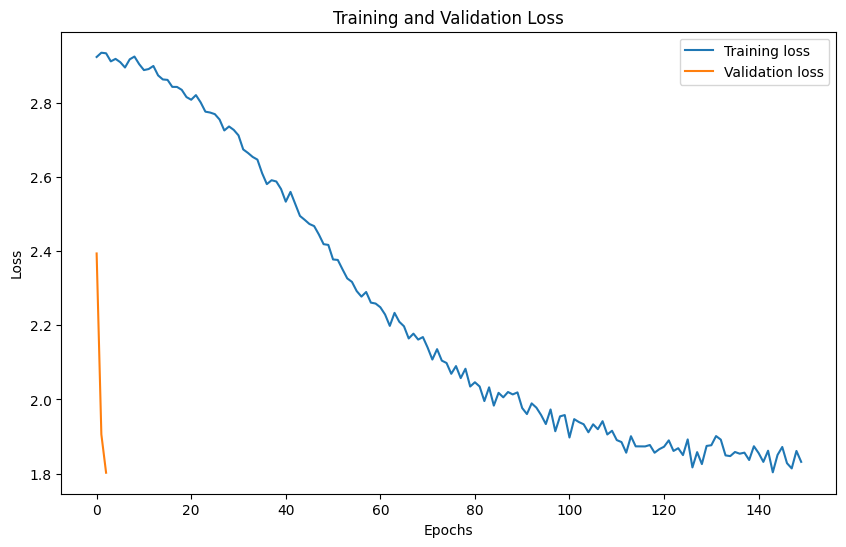

'\nmodel = XLMRobertaForTokenClassification.from_pretrained(model_name, num_labels=len(unique_labels))\n\ndef compute_metrics(p):\n    predictions, labels = p.predictions, p.label_ids\n    predictions = np.argmax(predictions, axis=2)\n\n    # Flatten both the predictions and labels\n    true_labels = labels.flatten()\n    pred_labels = predictions.flatten()\n\n    # Exclude ignored index (specifically -100)\n    true_labels = true_labels[true_labels != -100]\n    pred_labels = pred_labels[pred_labels != -100]\n\n    accuracy = accuracy_score(true_labels, pred_labels)\n    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=\'macro\')\n    return {\'accuracy\': accuracy, \'f1\': f1, \'precision\': precision, \'recall\': recall}\n\n# Ensure that training_args is defined as per your requirements\ntraining_args = TrainingArguments(\n    output_dir=\'./results\',          # output directory\n    num_train_epochs=3,              # number of training e

In [49]:
model = XLMRobertaForTokenClassification.from_pretrained(model_name, num_labels=len(unique_labels))

# 1. Freeze all layers except the classifier
for param in model.roberta.parameters():
    param.requires_grad = False

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def compute_metrics(p):
    predictions, labels = p.predictions, p.label_ids
    predictions = np.argmax(predictions, axis=2)

    true_labels = labels.flatten()
    pred_labels = predictions.flatten()

    valid_indices = true_labels != -100
    true_labels = true_labels[valid_indices]
    pred_labels = pred_labels[valid_indices]

    # Simple accuracy calculation
    accuracy = np.sum(true_labels == pred_labels) / len(true_labels)

    return {'accuracy': accuracy}


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  # Train for 10 epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    logging_steps=10,
    learning_rate=2e-5,
)

print("Starting training...")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

print("Training completed.")

# Visualize Training and Validation Loss
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting Accuracy vs Epochs
accuracy_scores = [log['eval_accuracy'] for log in trainer.state.log_history if 'eval_accuracy' in log]

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), accuracy_scores, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.show()

In [50]:
!nvidia-smi

Sun Mar  3 17:18:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              31W /  70W |   2499MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [48]:
def check_dataset_labels(dataset):
    # Check a few samples from the dataset to ensure labels are correctly assigned
    for i, sample in enumerate(dataset):
        if i > 5:  # Check the first 5 samples
            break
        labels = sample['labels'].numpy()
        print(f"Sample {i} labels: {labels}")
        print(f"Non -100 labels in sample {i}: {labels[labels != -100]}")

# Check the training and test datasets
check_dataset_labels(train_dataset)
check_dataset_labels(test_dataset)

Sample 0 labels: [-100 -100    2 -100   12 -100    6 -100   13 -100    2   15 -100    2
   15 -100    2 -100    4    4 -100    6    5 -100   13 -100    3 -100
    2 -100    5 -100   10    3 -100    4    4 -100    7 -100    4    4
 -100    4 -100    6 -100    2 -100   10 -100    2    3 -100   12 -100
    5 -100    4 -100    6    5 -100    2    2    2    2 -100    6 -100
    4 -100    2 -100    5 -100   10 -100    3 -100    6 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100